In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

In [4]:
df = pd.read_csv("../data/raw/online_retail.csv", encoding="ISO-8859-1")

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


### Initial Observations
- Number of rows: 1067370
- Missing values present in CustomerID
- InvoiceDate is stored as string
- Quantity contains negative values (refunds)

In [6]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [7]:
missing_customers = df["Customer ID"].isna().mean()
missing_customers

np.float64(0.22766872999172733)

Rows without CustomerID cannot be attributed to a customer and will be excluded from customer-level analysis in later phases.

In [8]:
df[df["Quantity"] < 0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


In [9]:
(df["Quantity"] < 0).mean()

np.float64(0.021501427338760374)

Negative quantities indicate refunds or cancellations.
These are retained as behavioral signals rather than dropped.

In [11]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [12]:
df["TotalPrice"].describe()

count    1.067371e+06
mean     1.806987e+01
std      2.924202e+02
min     -1.684696e+05
25%      3.750000e+00
50%      9.900000e+00
75%      1.770000e+01
max      1.684696e+05
Name: TotalPrice, dtype: float64

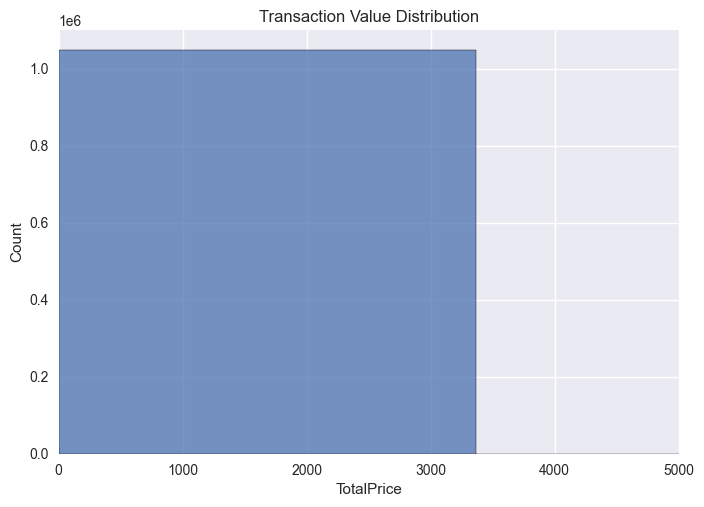

In [17]:
sns.histplot(df["TotalPrice"], bins=100)
plt.xlim(0,5000)
plt.title("Transaction Value Distribution")
plt.show()

In [19]:
customer_summary = (
    df.dropna(subset=["Customer ID"])
      .groupby("Customer ID")
      .agg(
          num_transactions=("Invoice", "nunique"),
          total_revenue=("TotalPrice", "sum"),
          first_purchase=("InvoiceDate", "min"),
          last_purchase=("InvoiceDate", "max")
      )
)

customer_summary.head()


,num_transactions,total_revenue,first_purchase,last_purchase
Customer ID,,,,
12346.0,17,-64.68,2009-12-14 08:34:00,2011-01-18 10:17:00
12347.0,8,5633.32,2010-10-31 14:20:00,2011-12-07 15:52:00
12348.0,5,2019.40,2010-09-27 14:59:00,2011-09-25 13:13:00
12349.0,5,4404.54,2009-12-04 12:49:00,2011-11-21 09:51:00
12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00


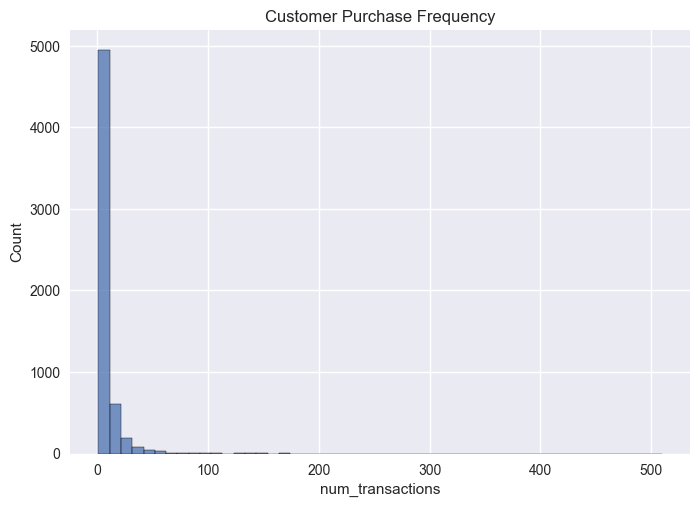

In [20]:
sns.histplot(customer_summary["num_transactions"], bins=50)
plt.title("Customer Purchase Frequency")
plt.show()


Most customers make very few purchases, while a small group purchases frequently. This confirms revenue concentration and justifies segmentation.


In [21]:
latest_date = df["InvoiceDate"].max()
customer_summary["days_since_last_purchase"] = (
    latest_date - customer_summary["last_purchase"]
).dt.days

customer_summary["days_since_last_purchase"].describe()


count    5942.000000
mean      201.908617
std       211.857936
min         0.000000
25%        24.000000
50%        95.000000
75%       380.000000
max       738.000000
Name: days_since_last_purchase, dtype: float64

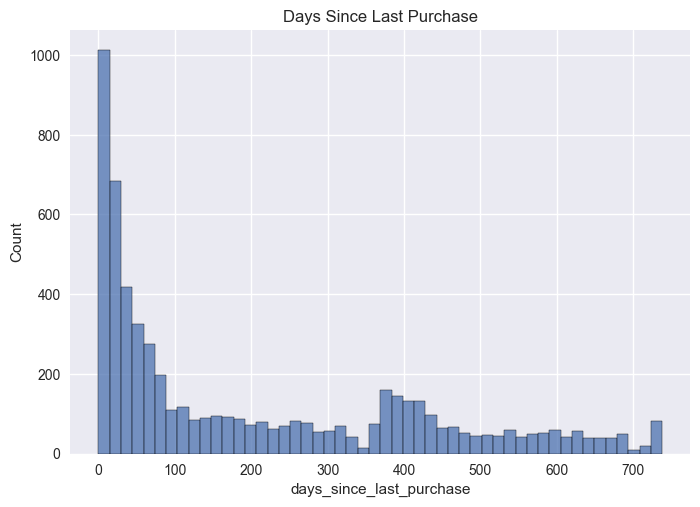

In [22]:
sns.histplot(customer_summary["days_since_last_purchase"], bins=50)
plt.title("Days Since Last Purchase")
plt.show()


This distribution will be used to select a churn threshold (e.g., 90 or 120 days)
in the next phase.
